This is an alternative version of Uplift Modeling VS Churn Prediction from my [previous experiment](https://www.kaggle.com/davinwijaya/why-you-should-start-using-uplift-modeling)
. The difference is in this notebook I use the Logistic Regression as the Machine Learning algorithm to compare Churn prediction Model with the Uplift Modeling.

# 1. Configurações iniciais
* Importação das bibliotecas
* Importação do dataset
* verificação das versões

In [10]:
import matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd, seaborn as sns, sklearn as sk
from sklearn.metrics import accuracy_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [11]:
# Checking for package version
print("Matplotlib Version", mpl.__version__)
print("Pandas Version", pd.__version__)
print("Seaborn Version", sns.__version__)
print("Sci-kit learn Version", sk.__version__)

Matplotlib Version 3.4.3
Pandas Version 1.3.4
Seaborn Version 0.11.2
Sci-kit learn Version 0.24.2


In [12]:
df_data_3 = pd.read_csv('turnover.csv', encoding = 'ISO-8859-1')
df_model_3 = df_data_3.copy()

# 2. Exploração dos dados
* Identificação das colunas
* Identificação da existencia de NULOS

In [13]:
# Explore dataset 3
df_data_3.head(5)

# https://www.kaggle.com/datasets/davinwijaya/employee-turnover
# stag                  - float             => Experiencia; 
# event                 - 0 E 1             => Demitido ou nao
# gender                - [m, f]    
# age                   - int
# industry              - list              => Setor da empresa
# profession            - list              => Setor do funcionário
# traffic               - list              => Forma que o funcionario chegou à empresa
# coach                 - list              => Presença de um treinador (treinamento) em estágio
# head_gender           - [m, f]            => sexo do supervisor
# greywage              - [grey, white]     => grey=paga taxas / white=nao paga taxas
# way                   - list              => how an employee gets to workplace (by feet, by bus etc);  
# extraversion          - 0 a 1
# independ              - 0 a 1
# selfcontrol           - 0 a 1
# anxiety               - 0 a 1
# novator               - 0 a 1


,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7


In [14]:
display(df_data_3.isnull().values.any())

False

Good, there is no null data.

# 3. Data preprocessing

In [15]:
# Renomeando o alvo
df_model_3 = df_model_3.rename(columns={'event': 'churn'})
# Renomeando a variavel de tratamento
df_model_3 = df_model_3.rename(columns={'coach': 'treatment'})

In [16]:
# Declara os parametros para codificação de rótulos
string1, string2, string3 = ['salary'], ['churn',
                                         'treatment',
                                         'BusinessTravel'], ['treatment']

for col in string3:
    display(col, df_model_3[col].unique())

'treatment'

array(['no', 'yes', 'my head'], dtype=object)

In [17]:
# Rotula manualmente o tratamento com 3 valores
df_model_3.treatment = df_model_3.treatment.map({'yes': 0, 'no': 1, 'my head':2})
df_model_3 = df_model_3.loc[df_model_3.treatment <=1].reset_index(drop=True)

Secondly, let's turn the rest of the string/object data into integer with the magical get_dummies function (One hot encoding) from Pandas package, so we can feed the data into the Random Forest Algorithm. Moreover, I add another dataframe df_model_inverse that will be useful for later:

In [18]:
# Codificação One-Hot:
df_model_3, df_model_inverse_3 = pd.get_dummies(df_model_3), pd.get_dummies(df_model_3)

Let's check the treatment's correlation to employee turnover:

In [19]:
def correlation_treatment(df:pd.DataFrame):
    """
    Clacula a correlação de tratamento
    """
    correlation = df[['treatment','churn']].corr(method ='pearson') 
    return(pd.DataFrame(round(correlation.loc['churn'] * 100,2)))

In [20]:
print("Dataset 3:", correlation_treatment(df_model_3).iloc[0,0])
print(df_model_3[['treatment','churn']].corr(method ='pearson'))

Dataset 3: -4.0
           treatment     churn
treatment   1.000000 -0.040031
churn      -0.040031  1.000000


Good, now all of the treatment features are negatively correlated. We will use the positive ones later at the end of this project. Next let's add the four uplift category for each datasets:

In [21]:
def declare_target_class(df:pd.DataFrame):
    """
    Declara a classe alvo
    """
    #CN - Control Non-Responders:
    df['target_class'] = 0 
    #CR - Control Responders:
    df.loc[(df.treatment == 0) & (df.churn == 0),'target_class'] = 1 
    #TN - Treadted Non-Responders:
    df.loc[(df.treatment == 1) & (df.churn == 1),'target_class'] = 2 
    #TR - Treated Responders:
    df.loc[(df.treatment == 1) & (df.churn == 0),'target_class'] = 3 
    return df

In [22]:
# Adiciona as 4 classes alvos (CN, CR, TN, TR)
df_model_3 = declare_target_class(df_model_3)

# 4. Machine Learning Modeling

Finally we're ready to start the machine learning process:

In [23]:
def split_data(df_model:pd.DataFrame):
    """
    Dividi os dados em dados de treinamento e dados de teste
    """
    X = df_model.drop(['churn','target_class'],axis=1)
    y = df_model.churn
    z = df_model.target_class
    X_train, X_test, \
    y_train, y_test, \
    z_train, z_test = train_test_split(
        X,
        y,
        z,
        test_size=0.3,
        random_state=42,
        stratify=df_model['treatment']
    )
    return X_train,X_test, y_train, y_test, z_train, z_test


def machine_learning(X_train:pd.DataFrame,
                     X_test:pd.DataFrame,
                     y_train:pd.DataFrame,
                     y_test:pd.DataFrame,
                     z_train:pd.DataFrame,
                     z_test:pd.DataFrame):
    """
    Machine learning consiste em treinamento de dados e processo de teste de dados
    Este metodo foi inicialmente escrito usando RandomForestClassifier, mas,
    neste trabalho vamos usar XGBClassifier 
    """
    # prepare a new DataFrame
    prediction_results = pd.DataFrame(X_test).copy()
    
    
    # train the ETP model
    # model_tp \
    # = RandomForestClassifier().fit(X_train.drop('treatment', axis=1), y_train)  
    # train the ETP model
    model_tp \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)  
    # prediction Process for ETP model 
    prediction_tp \
    = model_tp.predict(X_test.drop('treatment',axis=1))
    probability__tp \
    = model_tp.predict_proba(X_test.drop('treatment', axis=1))
    prediction_results['prediction_churn'] = prediction_tp
    prediction_results['proba_churn'] = probability__tp[:,1]

    
    # train the ETU model
    # model_etu \
    # = RandomForestClassifier().fit(X_train.drop('treatment', axis=1), z_train)
    model_etu \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), z_train)

    # prediction Process for ETU model 
    prediction_etu \
    = model_etu.predict(X_test.drop('treatment', axis=1))
    probability__etu \
    = model_etu.predict_proba(X_test.drop('treatment', axis=1))
    prediction_results['prediction_target_class'] = prediction_etu
    prediction_results['proba_CN'] = probability__etu[:,0] 
    prediction_results['proba_CR'] = probability__etu[:,1] 
    prediction_results['proba_TN'] = probability__etu[:,2] 
    prediction_results['proba_TR'] = probability__etu[:,3]
    prediction_results['score_etu'] = prediction_results.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    
    # add the churn and target class into dataframe as validation data
    prediction_results['churn'] = y_test
    prediction_results['target_class'] = z_test
    return prediction_results


def predict(df_model:pd.DataFrame):
    """Combining data split and machine learning process with Random Forest Classifier
    """
    X_train, X_test, y_train, y_test, z_train, z_test = split_data(df_model)
    
    prediction_results = machine_learning(X_train,
                                          X_test,
                                          y_train,
                                          y_test,
                                          z_train,
                                          z_test)
    print("Prediction has succeeded")
    return prediction_results

In [24]:
print("predicting dataset 3 ...")
prediction_results_3 = predict(df_model_3)

predicting dataset 3 ...
Prediction has succeeded


Prediction results are stored in prediction_results_1, prediction_results_2, and prediction_results_3 for dataset 1, dataset 2, and dataset 3, respectively.

# 5. Evaluating predictive performance

Now let's evaluate the predictive performance:

In [25]:
def cm_evaluation(df:pd.DataFrame):
    """Confusion matrix evaluation
    """  
    print("===================================")
    print("1. ETP's confusion matrix result:")
    confusion_etp = confusion_matrix(df['churn'], df['prediction_churn'])
    df_confusion_etp = pd.DataFrame(confusion_etp, columns = ['True','False'], index = ['Positive','Negative'])
    print(df_confusion_etp)
    
    print("-----------------------------------")
    
    print("2. ETU's confusion matrix result:")   
    confusion_etu = multilabel_confusion_matrix(df['target_class'], df['prediction_target_class'])
    print("a. CN's confusion matrix:")  
    df_cn = pd.DataFrame(confusion_etu[0], columns = ['True','False'], index = ['Positive','Negative'])
    print(df_cn)
    print("b. CR's confusion matrix:") 
    df_cr = pd.DataFrame(confusion_etu[1], columns = ['True','False'], index = ['Positive','Negative'])
    print(df_cr) 
    print("c. TN's confusion matrix:")
    df_tn = pd.DataFrame(confusion_etu[2], columns = ['True','False'], index = ['Positive','Negative'])
    print(df_tn) 
    print("d. TR's confusion matrix:") 
    df_tr = pd.DataFrame(confusion_etu[3], columns = ['True','False'], index = ['Positive','Negative'])
    print(df_tr)
    
    print("===================================")



In [Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62), the True Positive and False Negative are the amount of successful predictions and the True Negative and False Positive are the amount of failed predictions. Therefore, let's generate the confusion matrices:

In [26]:
cm_evaluation(prediction_results_3)

1. ETP's confusion matrix result:
          True  False
Positive    73     51
Negative    38     83
-----------------------------------
2. ETU's confusion matrix result:
a. CN's confusion matrix:
          True  False
Positive   218      4
Negative    18      5
b. CR's confusion matrix:
          True  False
Positive   223      5
Negative    13      4
c. TN's confusion matrix:
          True  False
Positive    95     52
Negative    34     64
d. TR's confusion matrix:
          True  False
Positive    96     42
Negative    38     69


Now, let's calculate the accuracy result:

In [27]:
def accuracy_evaluation(df:pd.DataFrame):
    """Accuracy evaluation
    """
    akurasi_cp = accuracy_score(df['churn'],
                                df['prediction_churn'])
    print('ETP model accuracy: %.2f%%' % (akurasi_cp * 100.0))
    
    
    akurasi_uplift = accuracy_score(df['target_class'],
                                    df['prediction_target_class'])
    print('ETU model accuracy: %.2f%%' % (akurasi_uplift * 100.0))

In [28]:
accuracy_evaluation(prediction_results_3)

ETP model accuracy: 63.67%
ETU model accuracy: 57.96%


Wow, seems like ETP models are much better than ETU models in terms of prediction accuracy. That makes sense anyway, because ETP models only predict two possible outcomes (The employee is turnover or stay), where ETU models predict four possible outcomes (Persuadables, Sure Things, Lost Causes, and Sleeping Dogs/Do-not-disturbs). But will ETP will also have a better performance in solving the employee turnover (prescriptive performance)? Let's find out.

# 6. Evaluating prescriptive performance

Now let's use the prediction results to solve the problem. As explained before, for ETP model employees are ranked by their turnover probability. Employees with the highest turnover probability will be targeted with a retention campaign (the treatment features declared before). On the other side, the ETU models are ranked by its uplift score with LGWUM's formulation.

In [29]:
def sorting_data(df:pd.DataFrame):
    """
    Function to sort data
    """
    # Set up new DataFrames for ETP model and ETU model
    df_c = pd.DataFrame({'n':[], 'target_class':[]})
    df_u = df_c.copy()
    df_c['target_class'] = df['target_class']
    df_u['target_class'] = df['target_class']
    
    
    # Add quantiles
    df_c['n'] = df.proba_churn.rank(pct=True, ascending=False)
    df_u['n'] = df.score_etu.rank(pct=True, ascending=False)
    df_c['score'] = df['proba_churn']
    df_u['score'] = df['score_etu']
    
    
    # Ranking the data by deciles
    df_c = df_c.sort_values(by='n').reset_index(drop=True)
    df_u = df_u.sort_values(by='n').reset_index(drop=True)
    df_c['model'], df_u['model'] = 'CP', 'Uplift'
    return df_c, df_u


def calculating_qini(df:pd.DataFrame):
    """Function to measure the Qini value
    """
    # Calculate the C, T, CR, and TR
    C, T = sum(df['target_class'] <= 1), sum(df['target_class'] >= 2)
    df['cr'] = 0
    df['tr'] = 0
    df.loc[df.target_class  == 1,'cr'] = 1
    df.loc[df.target_class  == 3,'tr'] = 1
    df['cr/c'] = df.cr.cumsum() / C
    df['tr/t'] = df.tr.cumsum() / T
    
    
    # Calculate & add the qini value into the Dataframe
    df['uplift'] = df['tr/t'] - df['cr/c']
    df['random'] = df['n'] * df['uplift'].iloc[-1]
    # Add q0 into the Dataframe
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    qini = pd.concat([q0, df]).reset_index(drop = True)
    return qini


def merging_data(df_c:pd.DataFrame, df_u:pd.DataFrame):
    """Function to add the 'Model' column and merge the dataframe into one
    """
    df_u['model'] = 'ETU'
    df_c['model'] = 'ETP'
    df = pd.concat([df_u, df_c]).sort_values(by='n').reset_index(drop = True)
    return df


def plot_qini(df:pd.DataFrame):
    """Function to plot qini
    """
    # Define the data that will be plotted
    order = ['ETU','ETP']
    ax = sns.lineplot(x='n', y=df.uplift, hue='model', data=df,
                      style='model', palette=['red','deepskyblue'],
                      style_order=order, hue_order = order)
    
    
    # Additional plot display settings
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=30)
    plt.ylabel('Uplift',fontsize=30)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=30)
    ax.tick_params(labelsize=24)
    ax.legend(handles=handles[1:], labels=labels[1:])
    ax.plot([0,1], [0,df.loc[len(df) - 1,'uplift']],'--', color='grey')
    return ax


def evaluation_qini(prediction_results:pd.DataFrame):
    """Function to combine all qini evaluation processes
    """
    df_c, df_u = sorting_data(prediction_results)
    qini_c, qini_u = calculating_qini(df_c), calculating_qini(df_u)
    qini = merging_data(qini_c, qini_u)
    ax = plot_qini(qini)
    return ax, qini

Text(0.5, 1.0, 'Qini Curve - Dataset 3')

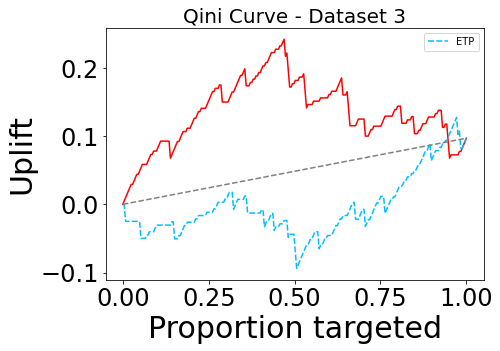

In [30]:
# Qini evaluation results for DataSet 3 with negative treatment correlation
ax, qini_3 = evaluation_qini(prediction_results_3)
plt.title('Qini Curve - Dataset 3',fontsize=20)


# save into pdf:
# plt.savefig('qini_3_n.pdf', bbox_inches='tight')

In [31]:
# The process to inverse treatment's parameter
df_model_inverse_3.treatment = df_model_inverse_3.treatment.replace({0: 1, 1: 0})

In [32]:
# Recalculate the treatment correlation
display(correlation_treatment(df_model_inverse_3).iloc[0,0])

4.0

Good, now the treatment features are positively correlated with employee turnover. This means, if we target the employees with this treatment, it's more likely that the employee turnover rate will be increased. So it'll be wise to use this treatment carefully. Okay, now let's repeat the prediction procedure once again:

In [33]:
# Add the target class feature to all three datasets
df_model_inverse_3 = declare_target_class(df_model_inverse_3)

In [34]:
# Do the prediction process once more time
prediction_results_inverse_3 = predict(df_model_inverse_3)

Prediction has succeeded


Text(0.5, 1.0, 'Qini Curve - Dataset 3')

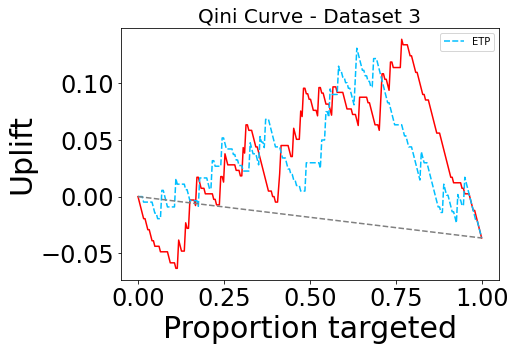

In [35]:
# Qini evaluation results for DataSet 3 with positive treatment correlation
ax, qini_inverse_3 = evaluation_qini(prediction_results_inverse_3)
plt.title('Qini Curve - Dataset 3',fontsize=20)


# save into pdf:
# plt.savefig('qini_3_p.pdf', bbox_inches='tight')